**Load regular packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

**Downloading data**

In [ ]:
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/housing_train.csv'
fn_dst = 'housing_train.csv'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

**Load the file into a pandas dataframe**

In [ ]:
df = pd.read_csv('housing_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1460
Number attributes per sample = 81


**Clean the Data**

Removing colums with missing data and rows with abnormal saleCondition to make regression easier. 

In [ ]:
df = df.dropna(axis=1)  # Remove the colums with missing values.

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt) #Number of colums decreased to 62

Number samples = 1460
Number attributes per sample = 62


In [ ]:
df = df.loc[df['SaleCondition'] == 'Normal' ] # Remove the rows for which sale condition is not normal.

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1198
Number attributes per sample = 62


**One-Hot coding the categorical variables (Arrange the Dataset)**

Using df.dtypes to get the data types of each variable.


In [ ]:
print(df.dtypes)

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
                  ...  
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
SalePrice         int64
Length: 62, dtype: object


We want to encode all categorical variables (dtype = object) as numerical values ----- One Hot Coding 

In [ ]:
# Remove the ID, month sold and sales price (it is the target)
ignore_vars = ['Id', 'MoSold', 'SalePrice']

# Find real and categorical variables
cols = df.columns
cat_vars = []
real_vars = []

for col in cols:
    
    if not (col in ignore_vars):
        if df.dtypes[col]  == 'object':
            cat_vars.append(col)
        else:
            real_vars.append(col)
                
print('Categorical variables = ' + str(cat_vars))
print('')
print('Real variables = ' + str(real_vars))


Categorical variables = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Real variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']


We next one-hot coded categorical variables. To do this, we use the pd.get_dummies command to convert the categorical variables to one hot coded items. We use the drop_first=True to replace each category with k values to k-1 variables. This removes linearly dependent columns.

In [ ]:
# Make data frames 
df_real = df[real_vars]
df_cat = df[cat_vars]

# Encode the categorical values into numerical values and forma a new data frame called df_cat_enc
df_cat_enc = pd.get_dummies(df_cat, drop_first=True)


Let's see result of One-Hot Coding by comparing both data frames.

In [ ]:
df_cat.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,TA,TA,Wood,GasA,Ex,Y,TA,Typ,Y,WD,Normal


In [ ]:
df_cat_enc.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,...,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_WD
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
5,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1



To get the data matrix, we then concatanate the real and encoded categorical tables and convert to an array. 

In [ ]:
df_enc = pd.concat((df_real, df_cat_enc), axis = 1)
X = np.array(df_enc)
print(X.shape)

xnames = df_enc.columns
print('Attributes = {}'.format(xnames))

(1198, 174)
Attributes = Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'Functional_Mod', 'Functional_Typ', 'PavedDrive_P', 'PavedDrive_Y',
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_WD'],
      dtype='object', length=174)


Target = sale price

In [ ]:
y = np.array(df['SalePrice'])
print(y)

[208500 181500 223500 ... 266500 142125 147500]


**Scaling the Data**

Split into training and test datasets.

In [ ]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)

Scale the variables as some variables represent different units and to make a sensible prediction we need to scale the variables.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create the scaler objects
xscal = StandardScaler()
yscal = StandardScaler()

# Fit and transform the training data
Xtr1 = xscal.fit_transform(Xtr)
ytr1 = yscal.fit_transform(ytr[:,None])

# Transform the test data
Xts1 = xscal.transform(Xts)
yts1 = yscal.transform(yts[:,None])

**Linear Regrssion without Regualarization**
--
We first fit the model with linear regression on the scaled training data. Then, we predict on the test data and measure the R^2 value. We get a terrible fit.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

# Fit
reg_ls = LinearRegression()
reg_ls.fit(Xtr1, ytr1)

# Training R^2
yhat1_tr = reg_ls.predict(Xtr1)
rsq_tr = r2_score(yhat1_tr, ytr1)
print('Training R^2 = %12.4e' % rsq_tr)

# Test R^2
yhat1_ts = reg_ls.predict(Xts1)
rsq_ts = r2_score(yts1, yhat1_ts)
print('Test R^2     = %12.4e' % rsq_ts)

Training R^2 =   9.3870e-01
Test R^2     =  -1.4600e+22


We get a terrible fit. The reason is that the matrix is ill-conditioned, meaning some of the columns in the data matrix Xtr are linearly dependent. We can get a better fit if we use a method called Ridge regression. Ridge regression is a type of regularization that we will discuss later, but we will use it here simply to improve the conditioning.


To understand Ridge regression, recall that the solution of the LS problem is:


beta = inv(A.T.dot(A)).dot(A.T.dot(y))

The problem occurs when the matrix, A.T.dot(A) has eigenvalues close to zero so the inverse blows up. To avoid, Ridge regression instead computes,


**beta = inv(A.T.dot(A) + n*alpha*eye(n)).dot(A.T.dot(y))**

where n is the number of data samples and alpha is a small value to keep the eigenvalues positive. Ridge regression can be performed as follows.

In [ ]:
reg_ls = Ridge(alpha=1e-5)
reg_ls.fit(Xtr1, ytr1)
yhat1 = reg_ls.predict(Xts1)
rsq = r2_score(yts1, yhat1)
print('Test R^2     = %f' % rsq)

Test R^2     = 0.884300


we convert the predicted targets back to the original scaling with the inverse_transform method in the scaler to get **yhat**.

Text(0, 0.5, 'Actual')

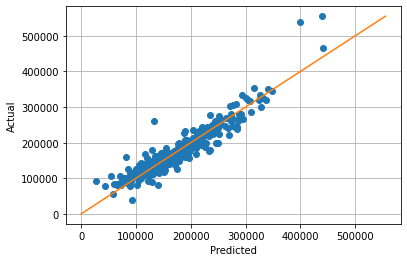

In [ ]:
yhat = yscal.inverse_transform(yhat1)

yline = np.array([0, np.max(yts)])
plt.plot(yhat, yts, 'o')
plt.plot(yline, yline)
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')

Print the features with 10 highest co-effecients (Model selection)

In [ ]:
coeff_ls = reg_ls.coef_.ravel()
nprint = 10
I = np.argsort(np.abs(coeff_ls))
I = np.flipud(I)
for i in range(nprint):
    j = I[i]
    print('%20s %f' % (xnames[j], coeff_ls[j]) )

           GrLivArea 0.286281
            2ndFlrSF 0.242110
      KitchenQual_TA -0.214960
      KitchenQual_Gd -0.211441
           YearBuilt 0.186527
 Exterior2nd_CmentBd 0.168908
 Exterior1st_CemntBd -0.149628
         OverallQual 0.149495
        ExterQual_TA -0.149352
        ExterQual_Gd -0.143918


We can also try to find the variables that do not matter. But, this is harder since it appears that most coefficients are non-zero. We can see this from both the stem plot (left) and the sorted coefficients (right). It is hard to discard any coefficients.

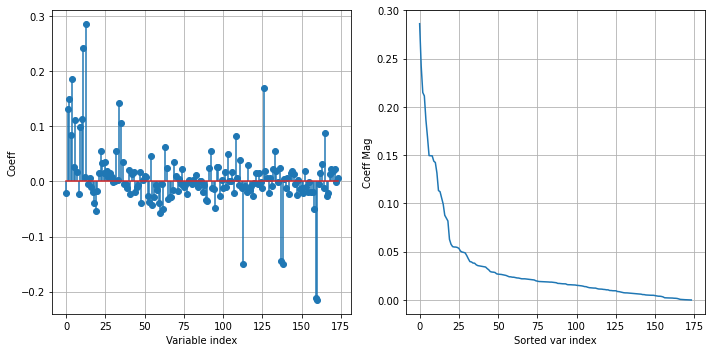

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_ls, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_ls = np.flipud(np.sort(np.abs(coeff_ls)))
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.tight_layout()

**LASSO Regression**
---
In Lasso regression we minimuze an objective of the form:

**betahat = argmin (1/2/n)*\| y - A.dot(beta) \|^2 + alpha * \| beta \|_1**

The term \| beta \|_1 = \sum_j |beta[j]| is called the regularizer and the scaling alpha is the regularization level. When alpha=0 we get the regular least squares fit. But, as we take higher values of alpha we force the fit to find more sparse solutions meaning solutions with larger number of terms with beta[j]=0.


We can perform Lasso regression with the Lasso method in sklearn as follows.

In [ ]:
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

alpha = 3e-3 #Randomely selected right now.

reg = Lasso(alpha=alpha)
reg.fit(Xtr1, ytr1)

yhat1 = reg.predict(Xts1)
req = r2_score(yts1, yhat1)

print('Test R^2= %f' % rsq)

Test R^2= 0.884300


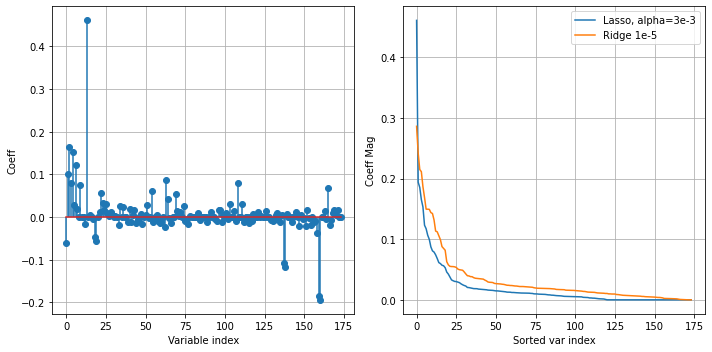

In [ ]:
coeff_lasso = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_lasso = np.flipud(np.sort(np.abs(coeff_lasso)))
plt.plot(coeff_sort_lasso)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, alpha=3e-3', 'Ridge 1e-5'])
plt.tight_layout()

Selecting aplha by cross validation -> k fold validation

In [ ]:
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

# Alpha values to test -> taking in log scale to cover wide range
alphas = np.logspace(-6,-1,40)
nalpha = len(alphas)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = y[Itr]
    Xts = X[Its,:]
    yts = y[Its]
    
    # Fit and transform the data -> Scaling on the x and y
    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)
    ytr1 = yscal.fit_transform(ytr[:,None])
    yts1 = yscal.transform(yts[:,None])

    for i, alpha in enumerate(alphas):

        # Fit on the training data
        reg = Lasso(alpha=alpha)
        reg.fit(Xtr1, ytr1)

        # Score on the test data
        yhat1 = reg.predict(Xts1)
        rsq[i, ifold] = r2_score(yts1, yhat1)
    
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_lasso_mean = np.mean(rsq, axis=1)
rsq_lasso_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


Plot the mean and SE as function of aplha

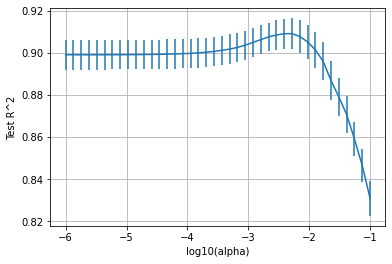

In [ ]:
plt.errorbar(np.log10(alphas), rsq_lasso_mean, yerr=rsq_lasso_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.show()

Get optimal value

In [ ]:
im = np.argmax(rsq_lasso_mean)
alpha_normal = alphas[im]
print('Alpha optimal (normal rule) = %12.4e' % alpha_normal)
print('Mean test R^2 (normal rule) = %7.3f' % rsq_lasso_mean[im])

Alpha optimal (normal rule) =   5.2233e-03
Mean test R^2 (normal rule) =   0.909


Retain the model at optimal value of alpha

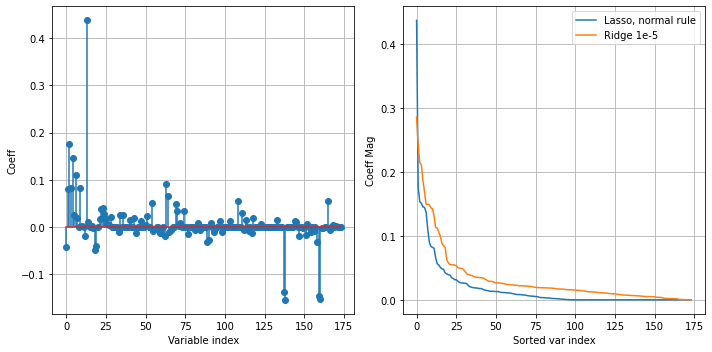

In [ ]:
# Fit on the entire data
reg = Lasso(alpha=alpha_normal)
reg.fit(Xtr1, ytr1)

# Plot the normalized coefficients
coeff_lasso_norm = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso_norm, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_norm = np.flipud(np.sort(np.abs(coeff_lasso_norm)))
plt.plot(coeff_sort_norm)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, normal rule', 'Ridge 1e-5'])
plt.tight_layout()

**One SE solution**


We can get an even more sparse solution using the one SE rule where we select the maximum alpha that achieves the maximum R^2 within one SE.

In [ ]:
# Target r^2
im = np.argmax(rsq_lasso_mean)
rsq_tgt = rsq_lasso_mean[im] - rsq_lasso_se[im]

# Find the least complex model with R^2 > rsq_tgt
I = np.where(rsq_lasso_mean >= rsq_tgt)[0]
iopt = I[-1]
alpha_onese = alphas[iopt]

print('Alpha optimal (one SE rule) = %12.4e' % alpha_onese)
print('Mean test R^2 (one SE rule) = %7.3f' % rsq_lasso_mean[iopt])

Alpha optimal (one SE rule) =   9.4267e-03
Mean test R^2 (one SE rule) =   0.905


Plot for this particular optimized alpha value

Optimal alpha = 0.009427


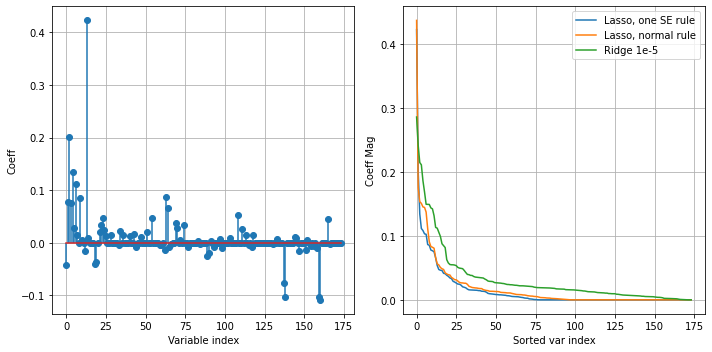

In [ ]:
# Fit on the entire data
reg = Lasso(alpha=alpha_onese)
reg.fit(Xtr1, ytr1)

# Plot the normalized coefficients
coeff_lasso_onese = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso_onese, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_onese = np.flipud(np.sort(np.abs(coeff_lasso_onese)))
plt.plot(coeff_sort_onese)
plt.plot(coeff_sort_norm)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, one SE rule', 'Lasso, normal rule', 'Ridge 1e-5'])
plt.tight_layout()

print("Optimal alpha = %f" % alpha_onese)

**Print the variable names of the top 10 coefficients** for the original Ridge regression model and the Lasso model with one SE rule. We see that two area variables (GrLivArea and 2ndFlrSF) have been replaced by one GrLivArea with more weight.

In [ ]:
Ils = np.argsort(np.abs(coeff_ls))
Ils = np.flipud(Ils)

Ilasso = np.argsort(np.abs(coeff_lasso_onese))
Ilasso = np.flipud(Ilasso)

nprint = 10
print('Ridge                        | Lasso')
print('-----------------------------|--------------------------------')
for i in range(nprint):
    jls = Ils[i]
    jlasso = Ilasso[i]
    print('%20s %7.2f |  %20s %7.2f' % (xnames[jls], coeff_ls[jls], xnames[jlasso], coeff_lasso_onese[jlasso]) )

Ridge                        | Lasso
-----------------------------|--------------------------------
           GrLivArea    0.29 |             GrLivArea    0.42
            2ndFlrSF    0.24 |           OverallQual    0.20
      KitchenQual_TA   -0.21 |             YearBuilt    0.13
      KitchenQual_Gd   -0.21 |            BsmtFinSF1    0.11
           YearBuilt    0.19 |        KitchenQual_TA   -0.11
 Exterior2nd_CmentBd    0.17 |          ExterQual_TA   -0.10
 Exterior1st_CemntBd   -0.15 |        KitchenQual_Gd   -0.10
         OverallQual    0.15 |  Neighborhood_NoRidge    0.09
        ExterQual_TA   -0.15 |           TotalBsmtSF    0.09
        ExterQual_Gd   -0.14 |               LotArea    0.08


**Ridge Regrssion**
---


In [ ]:
# Create cross-validation object
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

# Alpha values to test
alphas_ridge = np.logspace(-3,3,40)
nalpha = len(alphas)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = y[Itr]
    Xts = X[Its,:]
    yts = y[Its]
    
    # Fit and transform the data
    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)
    ytr1 = yscal.fit_transform(ytr[:,None])
    yts1 = yscal.transform(yts[:,None])

    for i, alpha in enumerate(alphas_ridge):

        # Fit on the training data
        reg = Ridge(alpha=alpha)
        reg.fit(Xtr1, ytr1)

        # Score on the test data
        yhat1 = reg.predict(Xts1)
        rsq[i, ifold] = r2_score(yts1, yhat1)
    
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_ridge_mean = np.mean(rsq, axis=1)
rsq_ridge_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


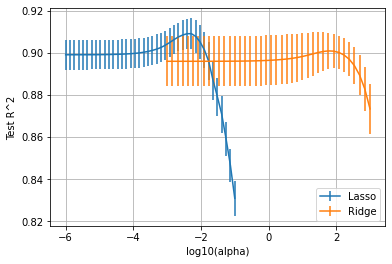

Optimal R^2 Lasso:  0.909068
Optimal R^2 Ridge:  0.900878


In [ ]:
plt.errorbar(np.log10(alphas), rsq_lasso_mean, yerr=rsq_lasso_se)
plt.errorbar(np.log10(alphas_ridge), rsq_ridge_mean, yerr=rsq_ridge_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.legend(['Lasso', 'Ridge'], loc='lower right')
plt.show()

print('Optimal R^2 Lasso:  %f' % np.max(rsq_lasso_mean))
print('Optimal R^2 Ridge:  %f' % np.max(rsq_ridge_mean))

**LASSO Path**
---


In [ ]:
import sklearn.linear_model

X1 = xscal.fit_transform(X)
y1 = xscal.fit_transform(y[:,None])

alphas_path = np.logspace(-5,1,40)
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X1, y1, alphas=alphas_path)


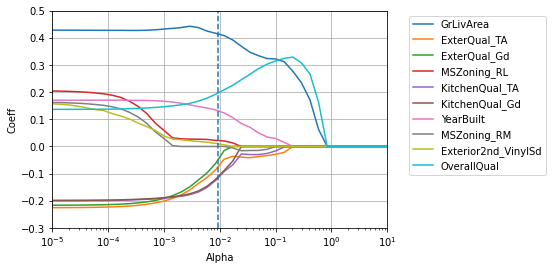

In [ ]:
nplot = 10
I = np.argsort(np.abs(coeffs[0,:,-1]))
I = np.flipud(I)
I = I[:nplot]

# Plot the paths of the coefficients
coeff_top = coeffs[0,I,:].T
plt.semilogx(alphas1,coeff_top)
plt.plot(alpha_onese*np.array([1,1]), [-0.3,0.5], '--')
plt.grid()
plt.legend(xnames[I], bbox_to_anchor=(1.05, 1))
plt.xlabel('Alpha')
plt.ylabel('Coeff')
plt.xlim([1e-5, 10])
_ = plt.ylim([-0.3, 0.5])